In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

### Data

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m  = x_train.shape
c = int(y_train.max() + 1)
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [7]:
model = Model(m, nh, c)

In [8]:
%%time
pred = model(x_train)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 126 ms


In [9]:
pred.grad_fn, x_train.grad_fn

(<AddmmBackward at 0x7f9e5654fac8>, None)

In [10]:
x_train.shape, pred.shape

(torch.Size([50000, 784]), torch.Size([50000, 10]))

### Cross entropy loss

In [11]:
def log_softmax(x): 
    return (x.exp() / x.exp().sum(dim=1)[:,None]).log()

In [12]:
sm_pred = log_softmax(pred)

In [13]:
sm_pred

tensor([[-2.4085, -2.3200, -2.3777,  ..., -2.4575, -2.3368, -2.1136],
        [-2.3977, -2.2351, -2.3729,  ..., -2.6175, -2.4418, -2.1439],
        [-2.3409, -2.3197, -2.2597,  ..., -2.4616, -2.2868, -2.2075],
        ...,
        [-2.3655, -2.3373, -2.2901,  ..., -2.5296, -2.3457, -2.1580],
        [-2.4473, -2.3079, -2.3129,  ..., -2.3619, -2.3897, -2.1626],
        [-2.4866, -2.3478, -2.3130,  ..., -2.4939, -2.3023, -2.1351]],
       grad_fn=<LogBackward>)

In [14]:
y_train[:3]

tensor([5, 0, 4])

In [15]:
sm_pred[0][5]

tensor(-2.2745, grad_fn=<SelectBackward>)

In [16]:
sm_pred[[0, 1, 2], [5, 0, 4]]

tensor([-2.2745, -2.3977, -2.1246], grad_fn=<IndexBackward>)

In [17]:
y_train.shape[0]

50000

In [18]:
def nll(inp, targ): return -inp[range(targ.shape[0]), targ].mean()

In [19]:
loss = nll(sm_pred, y_train)

In [20]:
loss

tensor(2.3244, grad_fn=<NegBackward>)

In [21]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [22]:
test_near(nll(log_softmax(pred), y_train), loss)

In [23]:
(pred - pred.max(-1, keepdim=True)[0]).exp().sum(-1)

tensor([8.2779, 7.9104, 8.3695,  ..., 7.8302, 8.5932, 8.0604],
       grad_fn=<SumBackward2>)

In [24]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:,None]).exp().sum(-1).log()

In [25]:
test_near(logsumexp(pred), pred.logsumexp(dim=-1))

In [26]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [27]:
test_near(nll(log_softmax(pred), y_train), loss)
pred.shape, y_train.shape, log_softmax(pred).shape, nll(log_softmax(pred), y_train).shape

(torch.Size([50000, 10]),
 torch.Size([50000]),
 torch.Size([50000, 10]),
 torch.Size([]))

In [28]:
test_near(F.nll_loss(F.log_softmax(pred, dim=-1), y_train), loss)
pred.shape, y_train.shape, F.log_softmax(pred, dim=-1).shape, F.nll_loss(F.log_softmax(pred, dim=-1), y_train).shape

(torch.Size([50000, 10]),
 torch.Size([50000]),
 torch.Size([50000, 10]),
 torch.Size([]))

In [29]:
test_near(F.cross_entropy(pred, y_train), loss)

In [30]:
def cross_entropy(inp, targ): return nll(log_softmax(inp), targ)

In [31]:
cross_entropy(pred, y_train)

tensor(2.3244, grad_fn=<NegBackward>)

## Basic training loop

In [32]:
loss_func = F.cross_entropy

In [33]:
def accuracy(out, yb):
    return (torch.argmax(out, dim=-1) == yb).float().mean()

In [34]:
bs = 64

xb = x_train[:bs]
preds = model(xb)
xb.shape, preds.shape
yb = y_train[:bs]
preds.shape, yb.shape

(torch.Size([64, 10]), torch.Size([64]))

In [35]:
lr = .5
epochs = 1

In [36]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.bias -= lr * l.bias.grad
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [37]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3258, grad_fn=<NllLossBackward>), tensor(0.8750))

## Using parameters and optim

### Parameters

In [38]:
model, list(model.named_children())

(Model(), [])

In [39]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [40]:
model = Model(m, nh, c)

In [41]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [42]:
list(model.named_children())

[('l1', Linear(in_features=784, out_features=50, bias=True)),
 ('l2', Linear(in_features=50, out_features=10, bias=True))]

In [43]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [44]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters(): p -= lr * p.grad
                model.zero_grad()

In [45]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0229, grad_fn=<NllLossBackward>), tensor(1.))

In [46]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k, v)
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p
    def __repr__(self): return f'{self._modules}'

In [47]:
mdl = DummyModule(m, nh, c)

In [48]:
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [49]:
[p.shape for p in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

In [50]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)]

In [51]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(layers): self.add_module(f'layer_{i}', l)
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [52]:
model = Model(layers)

In [53]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

In [54]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [55]:
model = SequentialModel(layers)

In [56]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [57]:
list(model.named_children())

[('layers', ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  ))]

In [58]:
list(model.layers.named_children())

[('0', Linear(in_features=784, out_features=50, bias=True)),
 ('1', ReLU()),
 ('2', Linear(in_features=50, out_features=10, bias=True))]

In [59]:
fit()

In [60]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1236, grad_fn=<NllLossBackward>), tensor(0.9375))

### nn.Sequential

In [61]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [62]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [63]:
list(model.named_children())

[('0', Linear(in_features=784, out_features=50, bias=True)),
 ('1', ReLU()),
 ('2', Linear(in_features=50, out_features=10, bias=True))]

### optim

In [64]:
class Optimizer():
    def __init__(self, params, lr=.5):
        self.params, self.lr = list(params), lr
    def step(self):
        with torch.no_grad(): 
            for p in self.params: p -= lr * p.grad
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [65]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [66]:
opt = Optimizer(model.parameters())

In [67]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        opt.step()
        opt.zero_grad()

In [68]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

In [69]:
from torch import optim

In [70]:
optim.SGD.step

<function torch.optim.sgd.SGD.step(self, closure=None)>

In [71]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [72]:
model, opt = get_model()

In [73]:
loss_func(model(xb), yb)

tensor(2.2421, grad_fn=<NllLossBackward>)

In [74]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        opt.step()
        opt.zero_grad()

In [75]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

In [76]:
loss, acc

(tensor(0.0637, grad_fn=<NllLossBackward>), tensor(1.))

In [77]:
assert acc > .7

## Dataset and DataLoader

### Dataset

In [78]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [79]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [80]:
xb, yb = train_ds[:5]
assert xb.shape == (5, 28**2)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [81]:
model, opt = get_model()

In [82]:
for epoch in range(epochs + 1):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: (i + 1) * bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [83]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > .7
loss, acc

(tensor(0.0110, grad_fn=<NllLossBackward>), tensor(1.))

### DataLoader

In [84]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i + self.bs]

In [85]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [86]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28**2)
assert yb.shape == (bs,)

tensor(3)

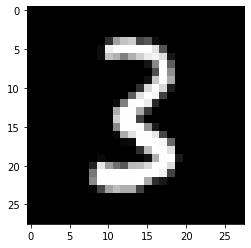

In [87]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [88]:
model, opt = get_model()

In [89]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [90]:
fit()

In [91]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > .7
loss, acc

(tensor(0.1146, grad_fn=<NllLossBackward>), tensor(1.))

### Random sampling

In [115]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
    def __iter__(self):
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [93]:
small_ds = Dataset(*train_ds[:10])

In [94]:
s = Sampler(small_ds, 3, False)
[idxs for idxs in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [95]:
s = Sampler(small_ds, 3, True)
[idxs for idxs in s]

[tensor([9, 1, 5]), tensor([6, 7, 2]), tensor([8, 4, 3]), tensor([0])]

In [96]:
[idxs for idxs in s]

[tensor([7, 9, 5]), tensor([8, 6, 3]), tensor([0, 4, 1]), tensor([2])]

In [116]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [132]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [133]:
train_dl = DataLoader(train_ds, train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, valid_samp, collate_fn=collate)

tensor(3)

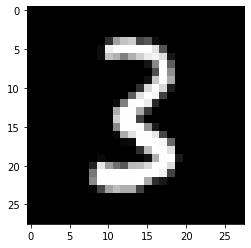

In [100]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [134]:
iter_train_dl = iter(train_dl)

tensor(6)

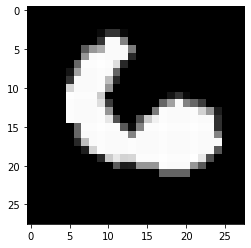

In [135]:
xb, yb = next(iter_train_dl)
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(1)

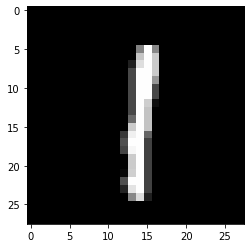

In [136]:
xb, yb = next(iter_train_dl)
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(9)

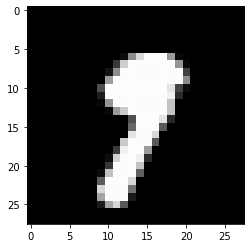

In [137]:
xb, yb = next(iter_train_dl)
plt.imshow(xb[0].view(28, 28))
yb[0]

In [138]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > .7
loss, acc

(tensor(0.1009, grad_fn=<NllLossBackward>), tensor(0.9375))

### Pytorch DataLoader

In [139]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [140]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [141]:
xb, yb = next(iter(train_dl))

In [142]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2388, grad_fn=<NllLossBackward>), tensor(0.8750))

In [144]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [148]:
iter_train_dl = iter(train_dl)

tensor(2)

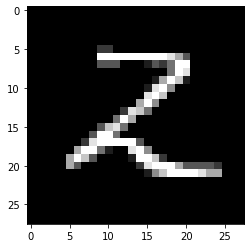

In [149]:
xb, yb = next(iter_train_dl)
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(9)

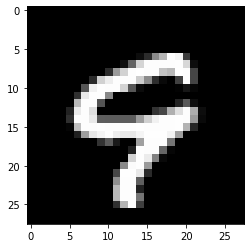

In [150]:
xb, yb = next(iter_train_dl)
plt.imshow(xb[0].view(28, 28))
yb[0]

In [152]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > .7
loss, acc

(tensor(0.1485, grad_fn=<NllLossBackward>), tensor(0.9531))

## Validation

In [156]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss / nv, tot_acc / nv)
    return tot_loss / nv, tot_acc / nv

In [157]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs),
           DataLoader(valid_ds, 2*bs, shuffle=False, **kwargs))

In [158]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2375) tensor(0.9166)
1 tensor(0.1219) tensor(0.9646)
2 tensor(0.1141) tensor(0.9656)
3 tensor(0.0989) tensor(0.9707)
4 tensor(0.2324) tensor(0.9410)


In [159]:
assert acc > .9

# fin